<a href="https://colab.research.google.com/github/pranjaldatta/creditcard-fraud-assignment/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# Git clone the repository

!git clone https://github.com/pranjaldatta/creditcard-fraud-assignment.git

Cloning into 'creditcard-fraud-assignment'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Unpacking objects: 100% (6/6), done.


In [3]:
# Get the dataset 

!cp /content/creditcard-fraud-assignment/creditcard.zip /content/
!unzip /content/creditcard-fraud-assignment/creditcard.zip

Archive:  /content/creditcard-fraud-assignment/creditcard.zip
  inflating: creditcard.csv          


In [105]:
# Imports!

import pandas as pd 
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

# Standard Scikit-Learn Imports
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [65]:
# reading the raw dataset from the csv file

raw_dataset = pd.read_csv("creditcard.csv")

In [66]:
# Let us have a look at the dataset!

raw_dataset.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [67]:
# Get the dataset columns!

print(raw_dataset.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


Fraud instances a % of total data: 0.17%
Non-Fraud instances a % of total data: 99.83%


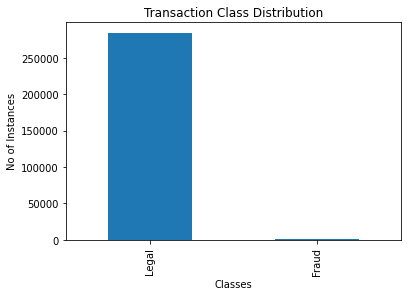

In [68]:
# Labels!
labels = ['Legal', 'Fraud']

# Lets just have a look at the distribution of the class labels
class_count = pd.value_counts(raw_dataset['Class'], sort=True)
class_count.plot(kind='bar')
plt.title('Transaction Class Distribution')
plt.xticks(range(2), labels)
plt.xlabel("Classes")
plt.ylabel('No of Instances')

# Lets calculate the the class occurance as a % of the total 
fraud_count = raw_dataset[raw_dataset['Class'] == 1]
valid_count = raw_dataset[raw_dataset['Class'] == 0]
total_count = len(raw_dataset)

print("Fraud instances a % of total data: {:.2f}%".format(fraud_count.shape[0] / total_count * 100))
print("Non-Fraud instances a % of total data: {:.2f}%".format(valid_count.shape[0] / total_count * 100))


In [69]:
# Since all columns apart from Time and amount are normalized, lets check how these
# two columms behave wrt to each class of transaction

comparison_df_amt = pd.concat([fraud_count.describe().Amount, valid_count.describe().Amount], 
                          keys=['Fraud', 'Valid'], axis=1)
print(comparison_df_amt)

             Fraud          Valid
count   492.000000  284315.000000
mean    122.211321      88.291022
std     256.683288     250.105092
min       0.000000       0.000000
25%       1.000000       5.650000
50%       9.250000      22.000000
75%     105.890000      77.050000
max    2125.870000   25691.160000


In [70]:
comparison_df_time = pd.concat([fraud_count.describe().Time, valid_count.describe().Time], 
                          keys=['Fraud', 'Valid'], axis=1)
print(comparison_df_time)

               Fraud          Valid
count     492.000000  284315.000000
mean    80746.806911   94838.202258
std     47835.365138   47484.015786
min       406.000000       0.000000
25%     41241.500000   54230.000000
50%     75568.500000   84711.000000
75%    128483.000000  139333.000000
max    170348.000000  172792.000000


In [72]:
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

raw_dataset["Amount_scaled"] = robust_scaler.fit_transform(
    raw_dataset['Amount'].values.reshape(-1, 1)
)

raw_dataset['Time_scaled'] = robust_scaler.fit_transform(
    raw_dataset['Time'].values.reshape(-1, 1)
)

In [73]:
amount_scaled = raw_dataset['Amount_scaled']
time_scaled = raw_dataset['Time_scaled']

raw_dataset.drop(['Amount_scaled', 'Time_scaled'], axis=1, inplace=True)
raw_dataset.drop(['Amount', 'Time'], axis=1, inplace=True)
raw_dataset.insert(0, 'amount_scaled', amount_scaled)
raw_dataset.insert(1, 'time_scaled', time_scaled)

raw_dataset.head(5)

,amount_scaled,time_scaled,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


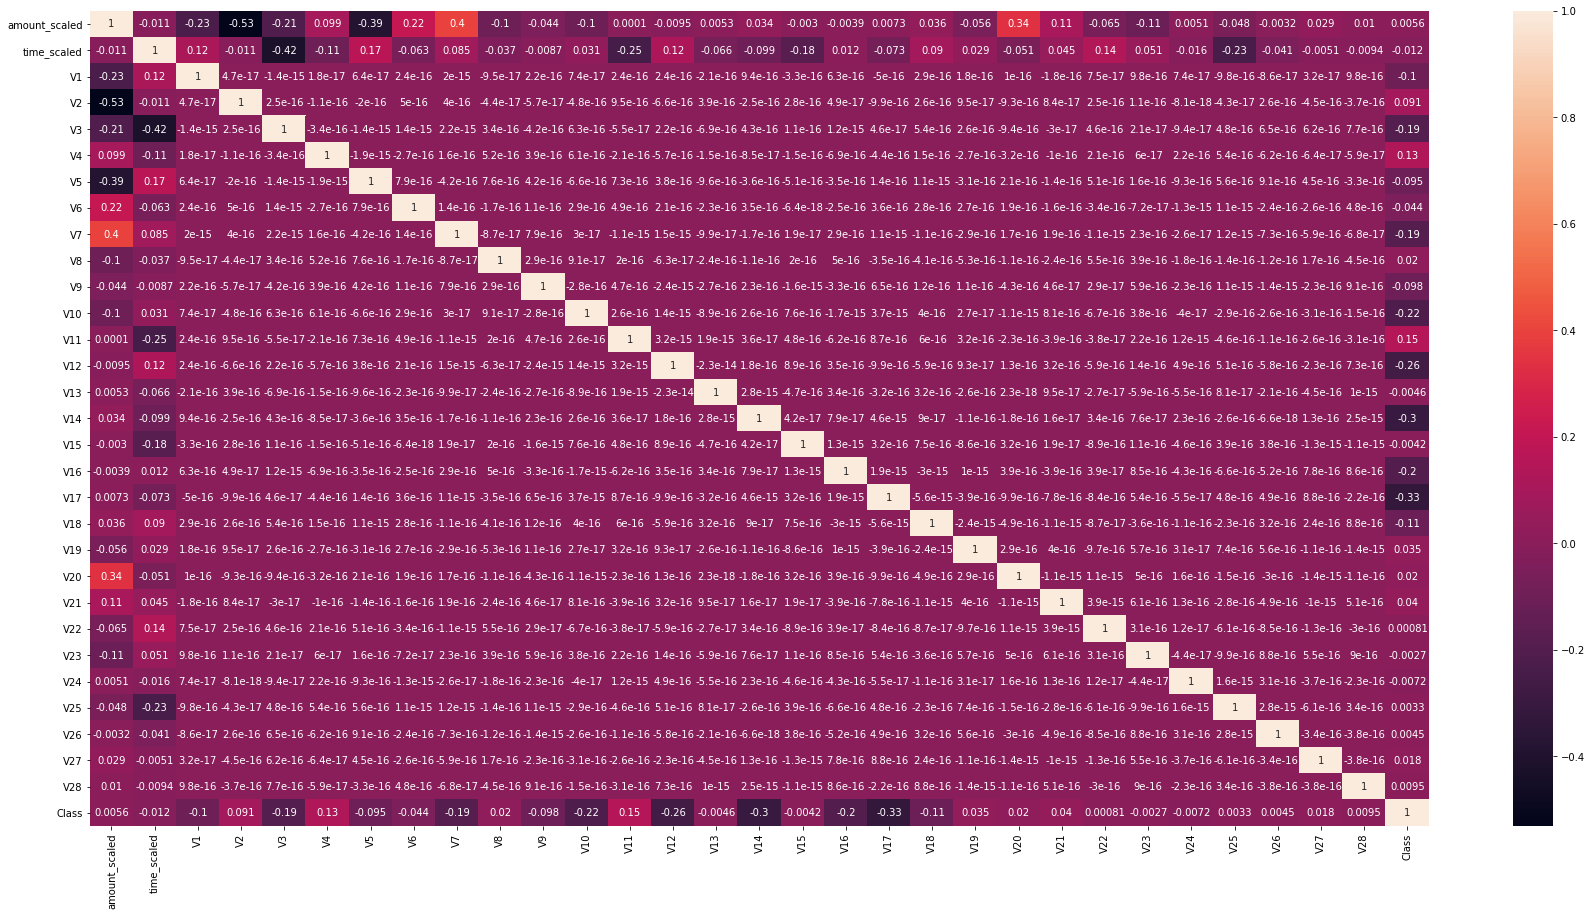

In [74]:
# Calculating the heatmap for the correlation matrix for the raw UNBALANCED 
# Dataset

fig, axes = plt.subplots(figsize=(30, 15))
sns.heatmap(raw_dataset.corr(), annot=True,  fmt='.2g', ax=axes)

In [76]:
scaled_fraud_count = raw_dataset[raw_dataset.Class == 1]
scaled_valid_count = raw_dataset[raw_dataset.Class == 0]

In [81]:
# Lets make a balanced dataset! i.e. both classes are present in 50:50 ratio 

FRAUD_PER = .95 # Percentage of fraudulant transactions to be included in the dataset

num_fraud = int(FRAUD_PER * scaled_fraud_count.shape[0])

fraud_idx = random.sample(range(0, scaled_fraud_count.shape[0]), num_fraud)
valid_idx = random.sample(range(0, scaled_valid_count.shape[0]), num_fraud)

fraud_subsample = scaled_fraud_count.iloc[fraud_idx]
valid_subsample = scaled_valid_count.iloc[valid_idx]

dataset_subsample = pd.concat([fraud_subsample, valid_subsample], axis=0)
dataset_subsample = dataset_subsample.sample(frac=1, random_state=120)

print(f"Scaled Fraud Subsample shape: {fraud_subsample.shape}\nScaled Valid Subsample Shape: {valid_subsample.shape}")

Scaled Fraud Subsample shape: (467, 31)
Scaled Valid Subsample Shape: (467, 31)


Text(0, 0.5, 'No of Instances')

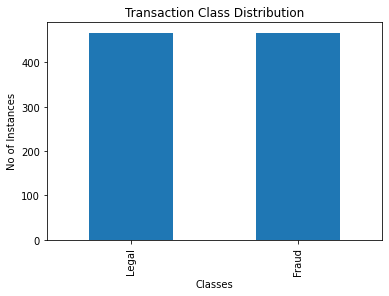

In [82]:
class_count = pd.value_counts([fraud_subsample.Class, valid_subsample.Class], sort=True)
class_count.plot(kind='bar')
plt.title('Transaction Class Distribution')
plt.xticks(range(2), labels)
plt.xlabel("Classes")
plt.ylabel('No of Instances')

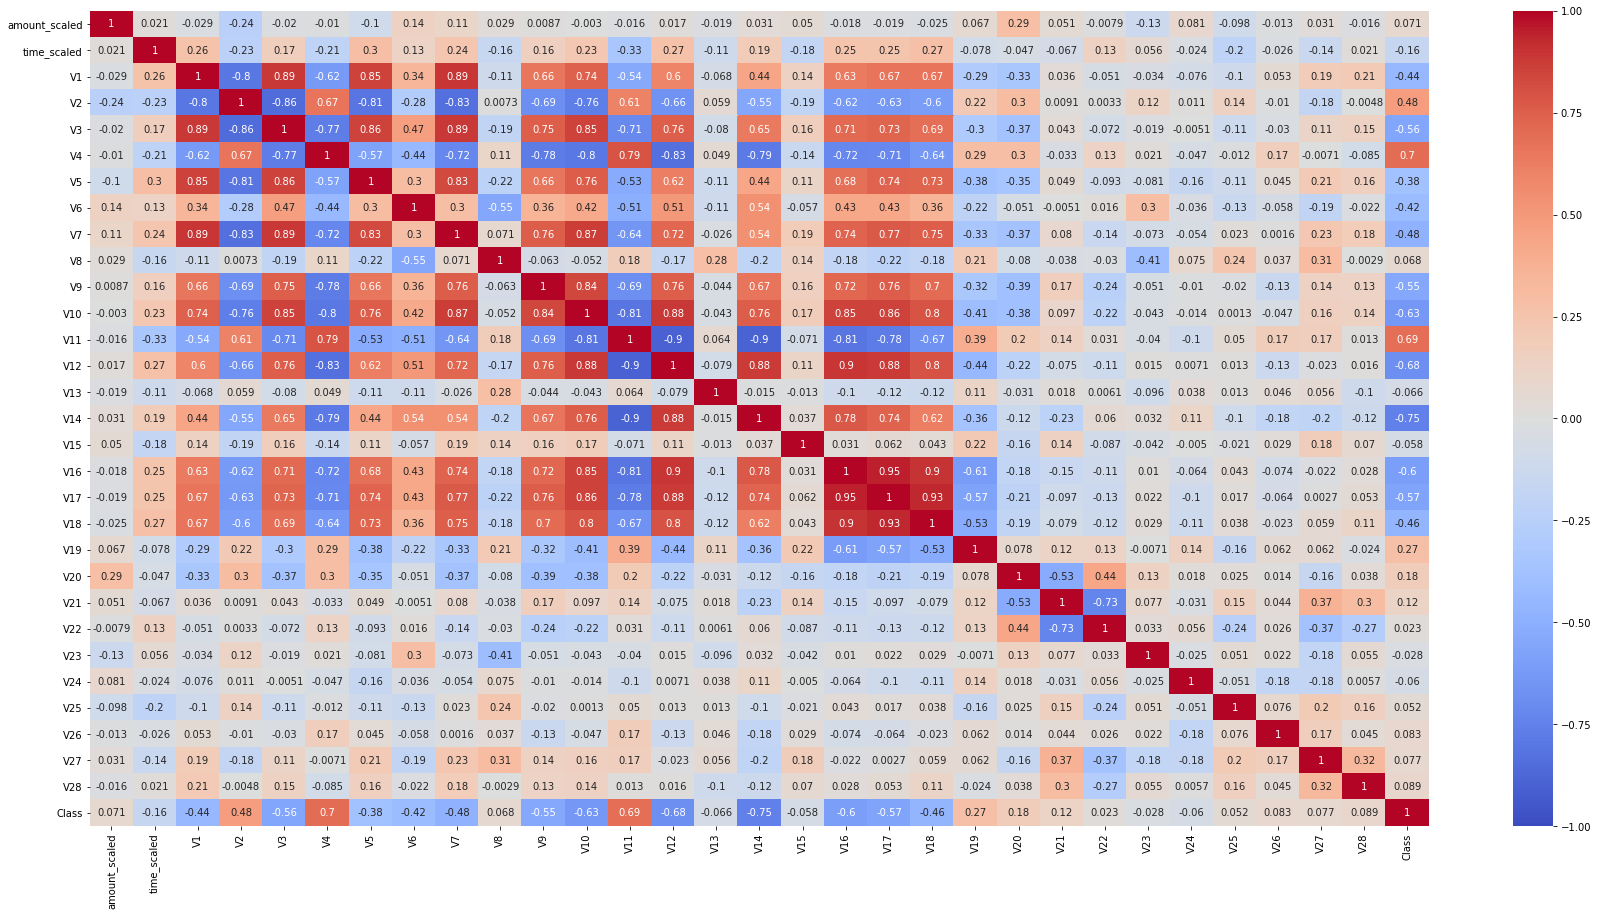

In [85]:
# Lets now make a heatmap out of the correlation matrix of the subsampled dataset
# to get some concrete information!

# From the heatmap, we understand that, V2, 4, 11, 19 are +vely correlated
# From the heatmap, we understand that, V17, 14, 12, 10 are -vely correlated

fig, axes = plt.subplots(figsize=(30, 15))
sns.heatmap(dataset_subsample.corr(), annot=True,  cmap='coolwarm', fmt='.2g', ax=axes, vmin=-1, vmax=+1, center=0)

In [88]:
# Split sub-sampled dataset into X and Y pair
X = dataset_subsample.drop('Class', axis=1)
Y = dataset_subsample.Class 

# TSNE 
start_time = time.time()
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
end_time = time.time()
print(f"TSNE reduction took: {end_time - start_time} s")

# PCA
start_time = time.time()
X_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
end_time = time.time() 
print(f"PCA reduction took: {end_time - start_time} s")

# Truncated SVD
start_time = time.time()
X_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
end_time = time.time()
print(f"Truncated SVD reduction took: {end_time - start_time} s")

TSNE reduction took: 6.023839712142944 s
PCA reduction took: 0.03752255439758301 s
Truncated SVD reduction took: 0.0036461353302001953 s


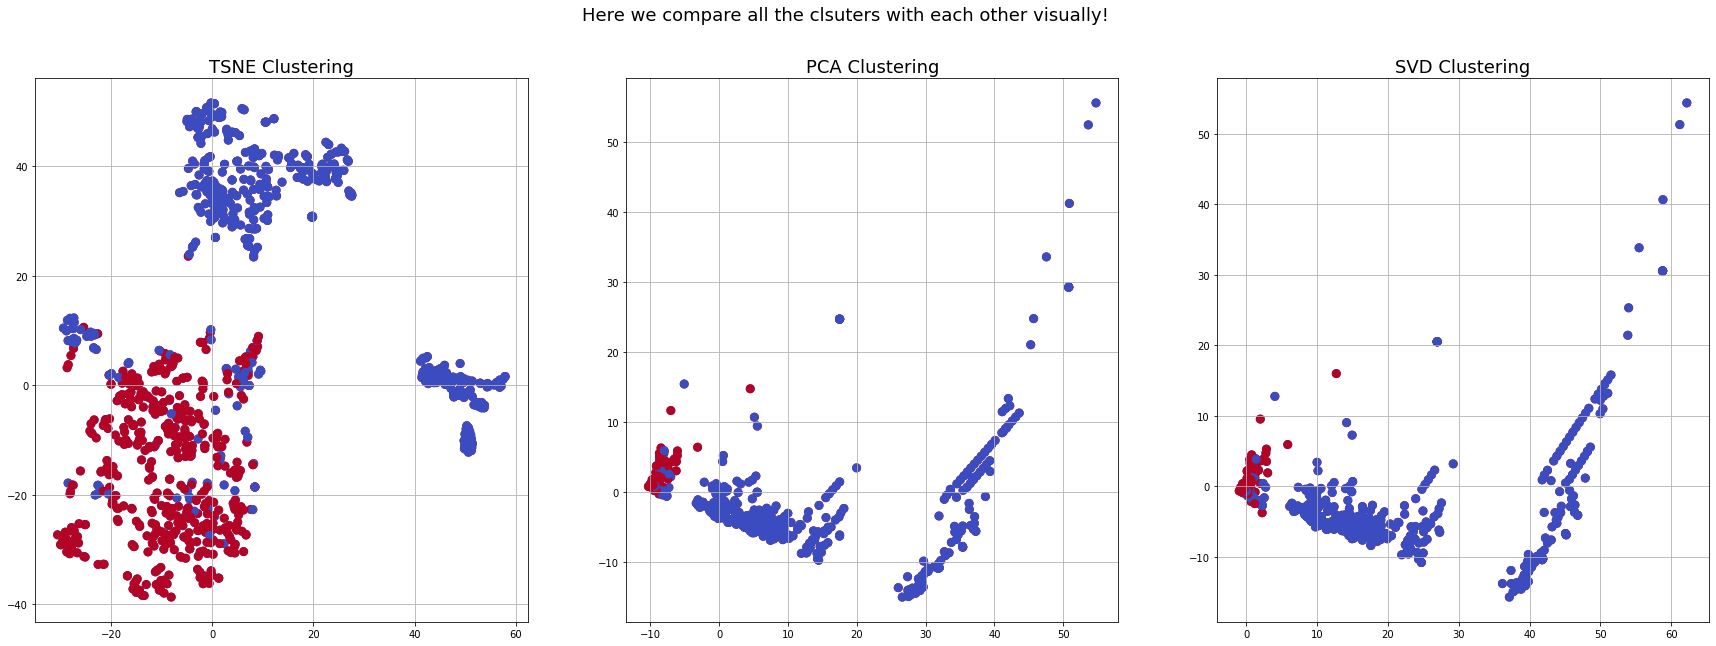

In [99]:
# Let us visualize the clusters!

figure, axes = plt.subplots(1, 3, figsize=(30, 10))
figure.suptitle('Here we compare all the clsuters with each other visually!', fontsize=18)

axes[0].grid(True)
axes[0].set_title('TSNE Clustering' , fontsize=18)
axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=(Y==0), cmap='coolwarm_r', label='Valid', linewidths=3)
axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=(Y==1), cmap='coolwarm_r', label='Fraud', linewidths=3)

axes[1].grid(True)
axes[1].set_title('PCA Clustering', fontsize=18)
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=(Y==0), cmap='coolwarm_r', label='Valid', linewidths=3)
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=(Y==1), cmap='coolwarm_r', label='Fraud', linewidths=3)

axes[2].grid(True)
axes[2].set_title('SVD Clustering', fontsize=18)
axes[2].scatter(X_svd[:, 0], X_svd[:, 1], c=(Y==0), cmap='coolwarm_r', label='Valid', linewidths=3)
axes[2].scatter(X_svd[:, 0], X_svd[:, 1], c=(Y==1), cmap='coolwarm_r', label='Fraud', linewidths=3)

plt.show()

In [102]:
# Lets split the dataset into training and validation datasets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=120)

# Converting to NumPy arrays since SKLearn Accepts only np format
x_train, x_test = x_train.values, x_test.values
y_train, y_test = y_train.values, y_test.values

print(f"Shape of x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}, y_test: {y_test.shape}")


Shape of x_train: (747, 30), y_train: (747,)
Shape of x_test: (187, 30), y_test: (187,)


In [112]:
# For ease of use, lets just intantiate our classifiers in dict object
# for rapid access

models = {
    "DecisionTree": DecisionTreeClassifier(), 
    "SVC": SVC(), 
    "KNN": KNeighborsClassifier(), 
    "LogReg": LogisticRegression()
}

In [113]:
count = 1
for key, model in models.items():
  
  start_time = time.time()
  model.fit(x_train, y_train)
  end_time = time.time()
  
  score = cross_val_score(model, x_train, y_train, cv=5)
  
  print("{}-> Model: {}, Fit Wall Time: {:.3f} secs , cross_val_score: {} %".format(
      count, model.__class__.__name__, end_time-start_time, round(score.mean(), 2)*100
  ))

  count += 1



1-> Model: DecisionTreeClassifier, Fit Wall Time: 0.017 secs , cross_val_score: 90.0 %
2-> Model: SVC, Fit Wall Time: 0.012 secs , cross_val_score: 93.0 %
3-> Model: KNeighborsClassifier, Fit Wall Time: 0.003 secs , cross_val_score: 93.0 %
4-> Model: LogisticRegression, Fit Wall Time: 0.030 secs , cross_val_score: 94.0 %


In [118]:
# Lets predict some values and see how we perform! 
preds = {}

for key, model in models.items():
  _pred = model.predict(x_test)
  _acc_score = accuracy_score(y_test, _pred)
  print(f"{model.__class__.__name__}: {round(_acc_score, 2) * 100} %")

DecisionTreeClassifier: 89.0 %
SVC: 93.0 %
KNeighborsClassifier: 94.0 %
LogisticRegression: 95.0 %


In [122]:
# Let's use GridsearchCV to fine tune our parameters!

gridcv_params = {
    "DecisionTree": {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}, 
    
    "SVC": {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}, 
    
    "KNN": {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}, 
    
    "LogReg": {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
}

optimized_models = {}

In [ ]:
# Running GridSearchCV on all the models!
for key, model in models.items():
  _grid_search_model = GridSearchCV(model, gridcv_params[key])
  _grid_search_model.fit(x_train, y_train)
  optimized_models.update({
      key: _grid_search_model.best_estimator_
  })


In [131]:
# Let's check whether our Cross-validation score has improved or not!

count = 1
for key, optimized_model in optimized_models.items():
  score = cross_val_score(optimized_model, x_train, y_train, cv=5)
  _pred = optimized_model.predict(x_test)
  acc_score = accuracy_score(y_test, _pred)
  print("{}-> Model: {}, cross-val-acc: {:.3f} %, accuracy: {:.3f} %".format(
      count, optimized_model.__class__.__name__, round(score.mean(), 3) * 100, 
      round(acc_score.mean(), 2) * 100
  ))
  count += 1

1-> Model: DecisionTreeClassifier, cross-val-acc: 92.400 %, accuracy: 91.000 %
2-> Model: SVC, cross-val-acc: 94.000 %, accuracy: 95.000 %
3-> Model: KNeighborsClassifier, cross-val-acc: 92.500 %, accuracy: 93.000 %
4-> Model: LogisticRegression, cross-val-acc: 93.800 %, accuracy: 94.000 %
